In [151]:
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder\
        .appName('Regression_Test')\
        .getOrCreate()
spark


In [152]:
# Importing library
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

from pyspark.ml.stat import Correlation
from pyspark.ml.regression import *
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder


# 
import matplotlib.pyplot as plt
import os


In [5]:
path = 'housing.csv'
df = spark.read.csv(path,
                    inferSchema=True,
                    header=True
                    )


In [6]:
df.limit(5).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [11]:
print(f'{df.count()}')

20640


In [12]:
print(f'number of rows {len(df.columns)}')

number of rows 10


# Drop missing values

In [13]:
df = df.na.drop()
df.count()

20433

# Format data

In [15]:
input_columns = [
    'total_bedrooms',
    'population',
    'households',
    'median_income']

dependent_var = 'median_house_value'

- MLib requires all input columns vectorized.
- dependent variable as label. So we rename it


In [24]:
df_renamed = df.withColumnRenamed(
    dependent_var,
    'label'
)

In [17]:
df_renamed.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'label',
 'ocean_proximity']

In [25]:
# making sure dependent variable is numeric
if str(df_renamed.schema['label'].dataType) != 'IntegerType':
    print('some')
    df_renamed = df_renamed.withColumn(
        'label',
        df_renamed['label'].cast(FloatType())
    )

some


In [26]:
df_renamed.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- label: float (nullable = true)
 |-- ocean_proximity: string (nullable = true)



- label is float type

In [40]:
# now for other columns
numeric_inputs = []
string_inputs = []

for i in df_renamed.columns:
    if str(df_renamed.schema[i].dataType) == 'StringType':
        new_col_name = f'{i}_num'
        string_inputs.append(new_col_name)
        indexer = StringIndexer(
            inputCol=i,
            outputCol=new_col_name
        )
        df_indexed = indexer.fit(
            df_renamed).transform(
                df_renamed
            )
    else:
        numeric_inputs.append(i)
        df_indexed = df_renamed

In [41]:
numeric_inputs, string_inputs

(['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'label'],
 ['ocean_proximity_num'])

In [42]:
df_indexed.limit(5).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,label,ocean_proximity,ocean_proximity_num
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,3.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,3.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


# Treat Outliers

In [43]:
d = {}
for i in numeric_inputs:
    d[i] = df_indexed.approxQuantile(
        i,
        [0.01, 0.99],
        0.25
    )


In [44]:
d

{'longitude': [-124.35, -114.31],
 'latitude': [32.54, 41.95],
 'housing_median_age': [1.0, 52.0],
 'total_rooms': [2.0, 39320.0],
 'total_bedrooms': [1.0, 6445.0],
 'population': [3.0, 35682.0],
 'households': [1.0, 6082.0],
 'median_income': [0.4999, 15.0001],
 'label': [14999.0, 500001.0]}

In [55]:
df.groupby().max('longitude').first().asDict()['max(longitude)']

-114.31

In [63]:
for col in numeric_inputs:
    skewness_ = df_indexed.agg(
        skewness(
            df_indexed[col]
        )
    ).collect()
    skew = skewness_[0][0]
    if skew > 1:
        df_indexed = df_indexed.withColumn(
            col,
            log(when(
                df_indexed[col] < d[col][0], d[col][0]
               ).when(
                   df_indexed[col] > d[col][1], d[col][1]
               ).otherwise(df_indexed[col] + 1)
               ).alias(col)
            )
        print(f'{col} has been treated for right skewness, skew = {skew}')
    
    elif skew < -1:
        df_indexed = df_indexed.withColumn(
            col,
            exp(when(
                df_indexed[col] < d[col][0], d[col][0]
               ).when(
                   df_indexed[col] > d[col][1], d[col][1]
               ).otherwise(df_indexed[col])
               ).alias(col)
            )
        print(f'{col} has been treated for left skewness, skew = {skew}')

total_rooms has been treated for right skewness, skew = 4.158511115086185
total_bedrooms has been treated for right skewness, skew = 3.4592923587675024
population has been treated for right skewness, skew = 4.959652416875933
households has been treated for right skewness, skew = 3.4135995729616138
median_income has been treated for right skewness, skew = 1.6444361858367003


In [62]:
d[numeric_inputs[0]][0], df[numeric_inputs[0]][0]

(-124.35, Column<'longitude[0]'>)

In [65]:
features_list = numeric_inputs + string_inputs
features_list

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'label',
 'ocean_proximity_num']

In [67]:
assembler = VectorAssembler(
    inputCols=features_list,
    outputCol='features'
)
final_data = assembler.transform(
    df_indexed).select('features',  'label')
final_data.show(5)

+--------------------+--------+
|            features|   label|
+--------------------+--------+
|[-122.23,37.88,41...|452600.0|
|[-122.22,37.86,21...|358500.0|
|[-122.24,37.85,52...|352100.0|
|[-122.25,37.85,52...|341300.0|
|[-122.25,37.85,52...|342200.0|
+--------------------+--------+
only showing top 5 rows



# Correlation searching

In [72]:
# incase of random forest may be not so effective
pearsonCorr = Correlation.corr(
    final_data,
    'features',
    'pearson').collect()[0][0]
pearsonCorr

DenseMatrix(10, 10, [1.0, -0.9246, -0.1094, 0.03, 0.0608, 0.1093, 0.0558, -0.0157, ..., 0.1455, -0.02, -0.0257, -0.0994, -0.0333, -0.0449, 0.021, 1.0], False)

In [80]:
array_ =  pearsonCorr.toArray()
array_

array([[ 1.        , -0.92461611, -0.10935655,  0.02996686,  0.06081674,
         0.10925941,  0.05582305, -0.01573692, -0.04539822, -0.43978672],
       [-0.92461611,  1.        ,  0.01189907, -0.03255172, -0.06824834,
        -0.13654279, -0.08820676, -0.08563664, -0.14463821,  0.39088465],
       [-0.10935655,  0.01189907,  1.        , -0.31391828, -0.27211227,
        -0.24301083, -0.24163013, -0.13746845,  0.10643205,  0.14546916],
       [ 0.02996686, -0.03255172, -0.31391828,  1.        ,  0.94586534,
         0.86458016,  0.93169968,  0.25190975,  0.15850639, -0.02000983],
       [ 0.06081674, -0.06824834, -0.27211227,  0.94586534,  1.        ,
         0.89752321,  0.97459262,  0.0144038 ,  0.05331112, -0.02574857],
       [ 0.10925941, -0.13654279, -0.24301083,  0.86458016,  0.89752321,
         1.        ,  0.93218972,  0.03178967, -0.02190432, -0.09943278],
       [ 0.05582305, -0.08820676, -0.24163013,  0.93169968,  0.97459262,
         0.93218972,  1.        ,  0.04694401

In [84]:
for i in array_:
    print(i[0])
    print(f'\n {i[1]}')

1.0

 -0.924616113116011
-0.924616113116011

 1.0
-0.109356548630242

 0.011899066824497439
0.029966862365051562

 -0.032551722082256276
0.060816744144712755

 -0.06824833979830804
0.10925941069250616

 -0.13654279494763852
0.05582305174490014

 -0.08820676105445614
-0.015736919978643103

 -0.08563663505541788
-0.04539821933444431

 -0.14463821157620982
-0.4397867223961979

 0.3908846539535469


# Split data

In [98]:
train, test = final_data.randomSplit([0.7, 0.3])

# from pyspark.sql.functions import percent_rank
# from pyspark.sql import Window

# df = df.withColumn(
#                    'rank', 
#                     percent_rank().over(
#                     Window.partitionBy().
#                     orderBy('date')))
# train_df = df.where(
#                     'rank <= .8'
#                    ).drop('rank')
# test_df = df.where(
#                     'rank > .8'
#                    ).drop('rank')

In [99]:
train.count()
train.show(5,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+--------+
|features                                                                                                                    |label   |
+----------------------------------------------------------------------------------------------------------------------------+--------+
|[-124.35,40.54,52.0,7.507141079727608,5.707110264748875,6.693323668269949,5.602118820879701,1.3899626248063144,94600.0,2.0] |94600.0 |
|[-124.3,41.84,17.0,7.8928255262511176,6.2766434893416445,7.126890808898808,6.124683390894205,1.394088904585803,103600.0,2.0]|103600.0|
|[-124.25,40.28,32.0,7.266128779556451,6.040254711277414,6.075346031088684,5.236441962829949,1.0789876455318097,76100.0,2.0] |76100.0 |
|[-124.23,40.54,52.0,7.899153483343097,6.118097198041348,7.050122520269059,6.077642243349034,1.406244036427511,106700.0,2.0] |106700.0|
|[-124.23,40.81,52.0,7.014814351275545,5.3471075

In [ ]:
# max_features = 0.5
# min_samples_leaf = 5
# max_samples = 200_000
# n_estimators = 40
# oob_score = True


##########################
# numTrees
# maxDepth

# featureSubsetStrategy
# minInfoGain
# minInstancesPerNode

In [103]:
rf = RandomForestRegressor(
    labelCol='label',
    featuresCol='features',
    seed=42)


paramGrid = (ParamGridBuilder()\
             .addGrid(rf.numTrees, [5, 20])
             .addGrid(rf.maxDepth, [ 2, 5, 10])
             .addGrid(rf.maxBins, [5, 10, 20])
             .build()
)
evaluator = RegressionEvaluator(metricName='rmse')

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=2)

fitModel = crossval.fit(train)

# best model
rf_best_model = fitModel.bestModel

# feature importannce

rm_fi = rf_best_model.featureImportances.toArray()

imp_scores = []
imp_scores = [float(i) for i in rm_fi]

fi_result = spark.createDataFrame(zip(
                        input_columns, imp_scores),
                        schema=['features', 'score'])
# predictions 
predictions = fitModel.transform(test)
rmse = evaluator.evaluate(predictions)
print(f'rmse of the model is = {rmse}')

print(fi_result.orderBy(
    fi_result['score'].desc()
    ).show(truncate=False))







22/03/07 13:50:41 WARN DAGScheduler: Broadcasting large task binary with size 1393.1 KiB
22/03/07 13:50:41 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/03/07 13:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1435.4 KiB
22/03/07 13:50:43 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/03/07 13:50:44 WARN DAGScheduler: Broadcasting large task binary with size 1394.8 KiB
22/03/07 13:50:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/03/07 13:50:52 WARN DAGScheduler: Broadcasting large task binary with size 1412.3 KiB
22/03/07 13:50:52 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/03/07 13:50:53 WARN DAGScheduler: Broadcasting large task binary with size 1456.4 KiB
22/03/07 13:50:54 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/03/07 13:50:55 WARN DAGScheduler: Broadcasting large task binary with size 1425.4 KiB
22/03/07 13:50:55 WARN DAGScheduler:

rmse of the model is = 9817.446149913087
+--------------+---------------------+
|features      |score                |
+--------------+---------------------+
|population    |0.012254274555153374 |
|total_bedrooms|0.009446806512804821 |
|households    |0.005580737465214972 |
|median_income |0.0018013917519767483|
+--------------+---------------------+

None


In [104]:

gbt = GBTRegressor(
    labelCol='label',
    featuresCol='features',
    seed=42)


paramGrid = (ParamGridBuilder()\
             .addGrid(gbt.maxDepth, [ 2, 5, 10])
             .addGrid(gbt.maxBins, [5, 10, 20])
             .build()
)
evaluator = RegressionEvaluator(metricName='rmse')

crossval = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=2)

fitModel = crossval.fit(train)

# best model
gbt_best_model = fitModel.bestModel

# feature importannce

gbt_fi = gbt_best_model.featureImportances.toArray()

imp_scores = []
imp_scores = [float(i) for i in gbt_fi]

fi_result = spark.createDataFrame(zip(
                        input_columns, imp_scores),
                        schema=['features', 'score'])
# predictions 
predictions = fitModel.transform(test)
rmse = evaluator.evaluate(predictions)
print(f'rmse of the model is = {rmse}')

print(fi_result.orderBy(
    fi_result['score'].desc()
    ).show(truncate=False))

22/03/07 13:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1009.1 KiB
22/03/07 13:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1048.3 KiB
22/03/07 13:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1045.7 KiB
22/03/07 13:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1046.1 KiB
22/03/07 13:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1046.7 KiB
22/03/07 13:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1047.9 KiB
22/03/07 13:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1050.3 KiB
22/03/07 13:57:09 WARN DAGScheduler: Broadcasting large task binary with size 1054.9 KiB
22/03/07 13:57:09 WARN DAGScheduler: Broadcasting large task binary with size 1063.6 KiB
22/03/07 13:57:09 WARN DAGScheduler: Broadcasting large task binary with size 1079.5 KiB
22/03/07 13:57:09 WARN DAGScheduler: Broadcasting large task binary with size 1104.6 KiB
22/03/07 13:57:09 WAR

rmse of the model is = 8565.56149552303
+--------------+---------------------+
|features      |score                |
+--------------+---------------------+
|population    |9.745763291273039E-4 |
|total_bedrooms|8.561848096959523E-4 |
|households    |7.863301963319607E-4 |
|median_income |4.8667166524541425E-4|
+--------------+---------------------+

None


In [124]:
print(f' best maximum depth = {gbt_best_model.getOrDefault("maxDepth")}')

 best maximum depth = 5


In [125]:
print(f'best number of trees is = {gbt_best_model.getNumTrees}')

best number of trees is = 20


In [105]:
predictions = gbt_best_model.transform(test)
predictions.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|[-124.3,41.8,19.0...| 85800.0| 89245.58589956215|
|[-124.27,40.69,36...| 79000.0| 74977.22023208543|
|[-124.26,40.58,52...|111400.0|114588.03692938644|
|[-124.23,41.75,11...| 73200.0| 75104.87605910233|
|[-124.22,41.73,28...| 78300.0|   74822.556430902|
|[-124.19,40.78,37...| 70000.0| 74786.26652608546|
|[-124.19,41.78,15...| 74600.0| 74803.75520070258|
|[-124.17,40.76,26...| 82800.0|   89010.862480897|
|[-124.17,40.79,43...| 70500.0| 74977.22023208543|
|[-124.17,40.8,52....| 60000.0| 57024.32338034982|
|[-124.17,40.8,52....| 62500.0| 56258.33830825579|
|[-124.17,40.8,52....| 75500.0| 74950.49663294357|
|[-124.16,40.78,43...| 82000.0|  75069.5652204469|
|[-124.16,40.78,46...| 81800.0|  74856.7745018888|
|[-124.16,40.79,46...| 90600.0| 89019.12946880804|
|[-124.16,40.8,52....| 74700.0| 75862.33325569314|
|[-124.16,41.74,15...| 69500.0|

In [107]:
predictions_rf = rf_best_model.transform(
    test
)
predictions_rf.show()






+--------------------+--------+-----------------+
|            features|   label|       prediction|
+--------------------+--------+-----------------+
|[-124.3,41.8,19.0...| 85800.0|85305.56191469732|
|[-124.27,40.69,36...| 79000.0|79332.47799395457|
|[-124.26,40.58,52...|111400.0|110895.4056477639|
|[-124.23,41.75,11...| 73200.0|76714.89970274208|
|[-124.22,41.73,28...| 78300.0|72708.92613653684|
|[-124.19,40.78,37...| 70000.0|72176.22708417095|
|[-124.19,41.78,15...| 74600.0|72054.31502542573|
|[-124.17,40.76,26...| 82800.0|91599.55932136692|
|[-124.17,40.79,43...| 70500.0| 75025.0417116134|
|[-124.17,40.8,52....| 60000.0|68562.49779809409|
|[-124.17,40.8,52....| 62500.0|68500.47398857027|
|[-124.17,40.8,52....| 75500.0|73934.66702796372|
|[-124.16,40.78,43...| 82000.0|82458.94922833475|
|[-124.16,40.78,46...| 81800.0| 88228.6281053954|
|[-124.16,40.79,46...| 90600.0|85334.18361294983|
|[-124.16,40.8,52....| 74700.0|73595.59329891499|
|[-124.16,41.74,15...| 69500.0| 74769.3558485407|


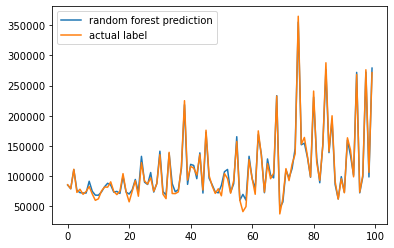

In [118]:
plt.plot(predictions_rf.toPandas()['prediction'].iloc[0:100],
         label='random forest prediction')
plt.plot(
    predictions_rf.toPandas()['label'].iloc[0:100],
            label='actual label')
#plt.plot(predictions.toPandas()['prediction'].iloc[0:100],
          #label='gradient boosted trees prediction')
plt.legend();

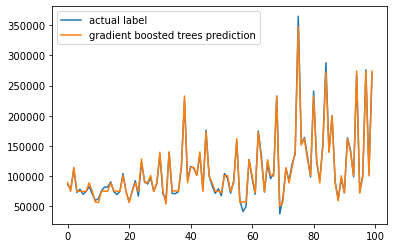

In [119]:
# plt.plot(predictions_rf.toPandas()['prediction'].iloc[0:100],
         #label='random forest prediction')
plt.plot(
    predictions_rf.toPandas()['label'].iloc[0:100],
            label='actual label')
plt.plot(predictions.toPandas()['prediction'].iloc[0:100],
          label='gradient boosted trees prediction')
plt.legend();

In [120]:
from datetime import datetime
timestamp = str(datetime.now())
path = 'Models/gbt_model_' + timestamp
gbt_best_model.save(path)

22/03/07 14:09:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/03/07 14:09:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
22/03/07 14:09:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
22/03/07 14:09:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
22/03/07 14:09:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
22/03/07 14:09:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 58.46% for 13 writers
22/03/07 14:09:07 WARN MemoryManager: Total allocation exceeds 95.

In [126]:
from pyspark.mllib.tree import RandomForestModel

In [129]:
gbt_best_model

GBTRegressionModel: uid=GBTRegressor_1c86c2d64ef6, numTrees=20, numFeatures=10

In [128]:

path

'Models/gbt_model_2022-03-07 14:09:06.469097'

In [137]:

from pathlib import Path

In [142]:
new_path = Path(path).absolute().as_posix()


In [154]:
RandomForestRegressor.load(path)

IllegalArgumentException: java.net.URISyntaxException: Relative path in absolute URI: gbt_model_2022-03-07 14:09:06.469097

In [ ]:
#import org.apache.spark.sql.SparkSession
#SparkSession spark = SparkSession
  #.builder()
  #.config("spark.sql.warehouse.dir", "file:///c:/tmp/spark-warehouse")
  #.getOrCreate()